In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


In [11]:
data_1=pd.read_csv("./cleaned_data.csv")
data_1.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0,January542024,202454March
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [14]:
data_1["TransactionStartTime"]=pd.to_datetime(data_1["TransactionStartTime"])

In [18]:
RFMS=pd.DataFrame({})

In [19]:
most_recent_txn = data_1.groupby('AccountId')['TransactionStartTime'].max()
RFMS['Recency'] = data_1['AccountId'].map(lambda x: (data_1['TransactionStartTime'].max() - most_recent_txn[x]).days)

transaction_count = data_1.groupby('AccountId')['TransactionId'].count()
RFMS['Frequency'] = data_1['AccountId'].map(transaction_count)


RFMS['Monetary'] = data_1['Amount'].abs()


RFMS['FraudPenalty'] = data_1['FraudResult'].apply(lambda x: -100 if x == 1 else 0)

RFMS.head()



,Recency,Frequency,Monetary,FraudPenalty
0,5,66,1000.0,0
1,0,30895,3679.0,0
2,81,2,500.0,0
3,5,26,20000.0,0
4,0,30895,644.0,0


In [21]:
RFMS['RFMS_Score'] = (0.3 * RFMS['Recency'] +  
                    0.4 * RFMS['Frequency'] + 
                    0.4 * RFMS['Monetary'] + 
                    RFMS['FraudPenalty'])
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score
0,5,66,1000.0,0,427.9
1,0,30895,3679.0,0,13829.6
2,81,2,500.0,0,225.1
3,5,26,20000.0,0,8011.9
4,0,30895,644.0,0,12615.6


In [22]:
threshold = RFMS['RFMS_Score'].median()

# Label each account as 'Good' or 'Bad'
RFMS['Risk'] = RFMS['RFMS_Score'].apply(lambda x: 'Good' if x >= threshold else 'Bad')

RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk
0,5,66,1000.0,0,427.9,Bad
1,0,30895,3679.0,0,13829.6,Good
2,81,2,500.0,0,225.1,Bad
3,5,26,20000.0,0,8011.9,Good
4,0,30895,644.0,0,12615.6,Good


In [36]:
risk_distribution = RFMS.groupby('RFMS_Bins')['Risk'].value_counts()
print(risk_distribution)

RFMS_Bins  Risk
0          Bad     47813
           Good       38
1          Good    47811
Name: count, dtype: int64


In [37]:
RFMS['RFMS_Bins'] = pd.qcut(RFMS['RFMS_Score'], q=5, labels=False)
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk,RFMS_Bins
0,5,66,1000.0,0,427.9,Bad,0
1,0,30895,3679.0,0,13829.6,Good,4
2,81,2,500.0,0,225.1,Bad,0
3,5,26,20000.0,0,8011.9,Good,3
4,0,30895,644.0,0,12615.6,Good,4


Risk            WoE
RFMS_Bins          
0               NaN
1               NaN
2          0.004389
3               NaN
4               NaN


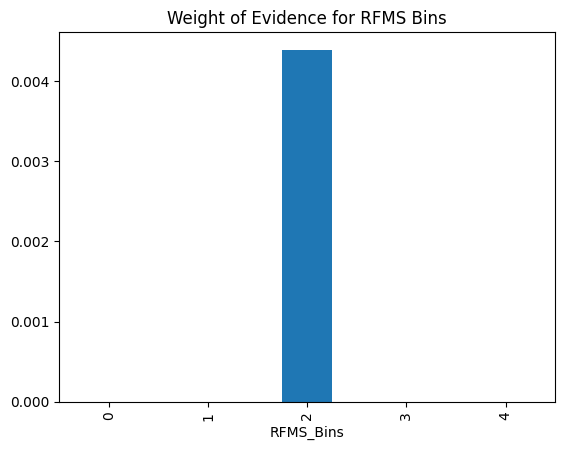

In [38]:


# Calculate WoE for each bin
grouped = RFMS.groupby('RFMS_Bins')['Risk'].value_counts(normalize=True).unstack()

# Calculate WoE (log of ratio of Good/Bad)
grouped['WoE'] = np.log(grouped['Good'] / grouped['Bad'])

# Print WoE values for each bin
print(grouped[['WoE']])

# Plot WoE values
import matplotlib.pyplot as plt
grouped['WoE'].plot(kind='bar')
plt.title('Weight of Evidence for RFMS Bins')
plt.show()


In [42]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
RFMS["Risk"] = label_encoder.fit_transform(RFMS["Risk"])
RFMS.head()

,Recency,Frequency,Monetary,FraudPenalty,RFMS_Score,Risk,RFMS_Bins
0,5,66,1000.0,0,427.9,0,0
1,0,30895,3679.0,0,13829.6,1,4
2,81,2,500.0,0,225.1,0,0
3,5,26,20000.0,0,8011.9,1,3
4,0,30895,644.0,0,12615.6,1,4


In [40]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

In [44]:
train, test = sc.split_df(RFMS, 'Risk', ratio = 0.7, seed = 999).values()

# Function to compute WOEs
var = train.drop(['Risk', 'RFMS_Bins', 'RFMS_Score'], axis = 1).columns
y_var = train['Risk']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks 
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks
  
woe_num(var, 'Risk')

{'Recency': [90.0],
 'Frequency': [1738.0, 4457.0, 30895.0],
 'Monetary': [4999.0, 9900.0, 10000.0, 9880000.0],
 'FraudPenalty': [0.0]}

In [53]:
data_woe=pd.read_csv("./cleaned_data.csv")
data_woe.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Unnamed: 16,Unnamed: 17
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256.0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000.00000,2018-11-15T02:18:49Z,2.0,0,January542024,202454March
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,3679.0,20.00000,2018-11-15T02:19:08Z,2.0,0,February33932024,202455March
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256.0,ProviderId_4,ProductId_1,airtime,ChannelId_3,500.0,500.00000,2018-11-15T02:44:21Z,2.0,0,March552026,202554March
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256.0,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,9900.64041,2018-11-15T03:32:55Z,2.0,0,April542027,202454March
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256.0,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644.00000,2018-11-15T03:34:21Z,2.0,0,May542028,202554March


In [56]:
data_woe["TransactionStartTime"]=pd.to_datetime(data_woe["TransactionStartTime"])

In [57]:
from sklearn.model_selection import train_test_split
data_woe['Hour'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.hour
data_woe['Day'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.day
data_woe['Month'] = pd.to_datetime(data_woe['TransactionStartTime']).dt.month
y = data_woe['FraudResult']

X = data_woe[['Amount', 'Value', 'CountryCode', 'ProviderId', 'ProductId', 
        'ProductCategory', 'ChannelId', 'CurrencyCode', 'TransactionStartTime']]
X = X.drop(columns=['TransactionStartTime'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
import pandas as pd
import numpy as np

def calculate_woe(df, feature, target):
    # Create bins for the feature (using pd.cut for continuous variables)
    df['bin'] = pd.qcut(df[feature], q=5, duplicates='drop')  # 5 bins, adjust as needed

    # Calculate total Good (Non-Fraud) and Bad (Fraud) counts
    total_good = len(df[df[target] == 0])  # Non-Fraud
    total_bad = len(df[df[target] == 1])  # Fraud

    # Group by bin and calculate Good (Non-Fraud) and Bad (Fraud) counts for each bin
    grouped = df.groupby('bin').agg(
        good_count=(target, lambda x: (x == 0).sum()),  # Non-Fraud counts
        bad_count=(target, lambda x: (x == 1).sum())    # Fraud counts
    )

    # Calculate proportions for Good and Bad
    grouped['good_dist'] = grouped['good_count'] / total_good  # Proportion of Good
    grouped['bad_dist'] = grouped['bad_count'] / total_bad     # Proportion of Bad

    # Calculate WoE
    grouped['WoE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])

    # Replace original feature values with WoE values
    # Map the WoE values back to the original dataframe
    woe_map = grouped['WoE'].to_dict()
    df[feature + '_woe'] = df['bin'].map(woe_map)

    # Drop temporary 'bin' column
    df.drop(columns=['bin'], inplace=True)

    return df, grouped[['good_count', 'bad_count', 'WoE']]

# Apply WoE to 'Amount' feature
df, woe_table = calculate_woe(data_woe, 'Amount', 'FraudResult')

# Display WoE table
print(woe_table)

# Now, 'Amount_woe' column has WoE transformed values for 'Amount'
print(df[['Amount', 'Amount_woe']].head())


                        good_count  bad_count       WoE
bin                                                    
(-1000000.001, -100.0]       19565          5  2.068193
(-100.0, 200.0]              18715          0       inf
(200.0, 1000.0]              23833          1  3.874960
(1000.0, 5000.0]             17322          0       inf
(5000.0, 9880000.0]          16034        187 -1.752509
    Amount  Amount_woe
0   1000.0    3.874960
1   3679.0         inf
2    500.0    3.874960
3  20000.0   -1.752509
4   -644.0    2.068193


In [71]:
data_woe.drop(columns=["CountryCode_woe"], inplace=True)

In [59]:
data_woe.drop(columns=['Unnamed: 16', 'Unnamed: 17'], inplace=True)

In [84]:
num_cols = ["int64", "float64"]
features= []
num_col=pd.DataFrame({})
for col in data_woe.columns:
    if data_woe[col].dtype.name in num_cols:  # Access the dtype of the column correctly
        features.append(col)
        num_col[col]=data_woe[col]
       
        if data_woe[col].isnull().sum() > 0:
            data_woe[col].fillna(data_woe[col].median(), inplace=True)  # Or dropna(), or any other strategy
    

In [83]:
import pandas as pd
import numpy as np

def calculate_woe(df, feature, target):
    # Create bins for the feature (using pd.cut for continuous variables)
    df['bin'] = pd.qcut(df[feature], q=5, duplicates='drop')  # 5 bins, adjust as needed

    # Calculate total Good (Non-Fraud) and Bad (Fraud) counts
    total_good = len(df[df[target] == 0])  # Non-Fraud
    total_bad = len(df[df[target] == 1])  # Fraud

    # Group by bin and calculate Good (Non-Fraud) and Bad (Fraud) counts for each bin
    grouped = df.groupby('bin').agg(
        good_count=(target, lambda x: (x == 0).sum()),  # Non-Fraud counts
        bad_count=(target, lambda x: (x == 1).sum())    # Fraud counts
    )

    # Calculate proportions for Good and Bad
    grouped['good_dist'] = grouped['good_count'] / total_good  # Proportion of Good
    grouped['bad_dist'] = grouped['bad_count'] / total_bad     # Proportion of Bad

    # Calculate WoE
    grouped['WoE'] = np.log(grouped['good_dist'] / grouped['bad_dist'])

    # Replace original feature values with WoE values
    # Map the WoE values back to the original dataframe
    woe_map = grouped['WoE'].to_dict()
    df[feature + '_woe'] = df['bin'].map(woe_map)

    # Drop temporary 'bin' column
    df.drop(columns=['bin'], inplace=True)

    return df, grouped[['good_count', 'bad_count', 'WoE']]

# Apply WoE to 'Amount' feature
df, woe_table = calculate_woe(df, 'Amount', 'FraudResult')

# Display WoE table
print(woe_table)

# Now, 'Amount_woe' column has WoE transformed values for 'Amount'
print(df[['Amount', 'Amount_woe']].head())


                        good_count  bad_count       WoE
bin                                                    
(-1000000.001, -100.0]       19565          5  2.068193
(-100.0, 200.0]              18715          0       inf
(200.0, 1000.0]              23833          1  3.874960
(1000.0, 5000.0]             17322          0       inf
(5000.0, 9880000.0]          16034        187 -1.752509
    Amount  Amount_woe
0   1000.0    3.874960
1   3679.0         inf
2    500.0    3.874960
3  20000.0   -1.752509
4   -644.0    2.068193


In [ ]:
def woebin(df, y, x, num_bins=5):
    # Create a dictionary to hold breaks for each feature
    breaks_dict = {}
    
    for feature in x:
        # Discretize the feature into bins
        discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='quantile')
        df[feature + '_bin'] = discretizer.fit_transform(df[[feature]]).astype(int)
        
        # Calculate the WoE for each bin
        woe_table = df.groupby(feature + '_bin')[y].agg(
            good_count=lambda x: (x == 0).sum(),
            bad_count=lambda x: (x == 1).sum()
        )
        
        # Calculate WoE
        total_good = woe_table['good_count'].sum()
        total_bad = woe_table['bad_count'].sum()
        
        woe_table['WoE'] = np.log((woe_table['good_count'] / total_good) / (woe_table['bad_count'] / total_bad))
        
        # Store breaks in the dictionary
        breaks_dict[feature] = {
            'bins': discretizer.bin_edges_,
            'woe': woe_table['WoE']
        }
    
    return breaks_dict

# Specify the features for WoE binning
features = ['Recency', 'Frequency', 'Monetary']

# Perform WoE binning
woe_results = woebin(RFMS, 'FraudResult', features)

# Print the results
for feature, result in woe_results.items():
    print(f'WoE Binning for {feature}:')
    print(result['woe'])

In [85]:
RFMS.isnull().sum()

Recency         0
Frequency       0
Monetary        0
FraudPenalty    0
RFMS_Score      0
Risk            0
RFMS_Bins       0
dtype: int64